# Movie Recommendation System for MovieLens 100K Dataset

## Library Imports

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.preprocessing
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
import tqdm

from datetime import datetime, timedelta
import pathlib
import random

c:\ProgramData\Anaconda3\envs\eleven\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


## Seeding Random Generators

In [2]:
SEED = 42
np.random.seed(SEED)
torch.random.manual_seed(SEED)
torch_geometric.seed.seed_everything(SEED)
random.seed(SEED)

## Loading the Dataset

In [3]:
BATCH_SIZE = 64
DATASET_DIR = pathlib.Path('../data/raw/ml-100k/')

In [4]:
class RatingDataset(Dataset):
    """Dataset containing tuples of `user_id, item_id, rating`.
    """
    def __init__(self, dataframe: pd.DataFrame):
        """Dataset containing tuples of `user_id, item_id, rating`.

        Args:
            dataframe (DataFrame): The dataset containing columns
            `user_id`, `item_id`, and `rating`.
        """
        super().__init__()
        self.items = list(zip(dataframe['user_id'] - 1, dataframe['item_id'] - 1, dataframe['rating']))
    
    def __len__(self) -> int:
        """Calculates the length of the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.items)
    
    def __getitem__(self, index: int) -> tuple[int, int, int]:
        """Returns the `index`-th item in the dataset.

        Args:
            index (int): The index of the item requested.

        Returns:
            tuple[int, int, int]: Tuple of `user_id`, `item_id`, `rating`.
            `rating` ranges from 1 to 5 inclusive.
        """
        return self.items[index]

In [5]:
# The user-given ratings are loaded and split into training, validation, and test sets.
ratings_df = pd.read_csv(DATASET_DIR / 'u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])
dataset = RatingDataset(ratings_df)
test_size = val_size = int(len(ratings_df) * .05)
train_size = len(ratings_df) - val_size - test_size

train_dataset, val_dataset, test_dataset = random_split(dataset, (train_size, val_size, test_size))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
# The movie data is loaded
item_columns = ['movie id', 'movie title', 'release date', 'video release date', 'IMDb URL']
GENRES = ['unknown', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
items_df = pd.read_csv(DATASET_DIR / 'u.item', sep='|', names=item_columns + GENRES, encoding="windows-1252")

In [7]:
# The user data is loaded.
user_columns = ['user id', 'age', 'gender', 'occupation', 'zip code']
users_df = pd.read_csv(DATASET_DIR / 'u.user', sep='|', names=user_columns, encoding="windows-1252")

## Processing User and Item Data

In [8]:
class UserEncoding:
    """Encodes user information into numerical format. Age is rescaled to be between
    0 and 1, gender and occupation are one-hot encoded.
    """
    def __init__(self):
        """Encodes user information into numerical format. Age is rescaled to be between
        0 and 1, gender and occupation are one-hot encoded.
        """
        self.age_scaler = sklearn.preprocessing.MinMaxScaler()
        self.gender_encoder = sklearn.preprocessing.LabelEncoder()
        self.occupation_encoder = sklearn.preprocessing.LabelEncoder()
        self.occupation_one_hot = sklearn.preprocessing.OneHotEncoder(sparse=False)

    def fit(self, dataframe: pd.DataFrame):
        """Fits all the preprocessing sklearn modules on the data.

        Args:
            dataframe (DataFrame): Dataframe containing the user information.
        """
        self.age_scaler.fit(dataframe.age.to_numpy().reshape(-1, 1))
        self.gender_encoder.fit(dataframe.gender.to_numpy().reshape(-1, 1))
        occupation = self.occupation_encoder.fit_transform(dataframe.occupation.to_numpy().reshape(-1, 1)).reshape(-1, 1)
        self.occupation_one_hot.fit(occupation)

    def transform(self, dataframe: pd.DataFrame) -> np.ndarray:
        """Transforms the user information and returs a numpy array
        with encoded values.

        Args:
            dataframe (DataFrame): Dataframe with user information.

        Returns:
            ndarray: Encoded user information.
        """
        age = self.age_scaler.transform(dataframe.age.to_numpy().reshape(-1, 1))
        gender = self.gender_encoder.transform(dataframe.gender.to_numpy().reshape(-1, 1)).reshape(-1, 1)
        occupation = self.occupation_encoder.transform(dataframe.occupation.to_numpy().reshape(-1, 1)).reshape(-1, 1)
        occupation = self.occupation_one_hot.transform(occupation)
        user_features = np.concatenate((age, gender, occupation), axis=1)
        return user_features

    def fit_transform(self, dataframe: pd.DataFrame) -> np.ndarray:
        """Fits all preprocessing modules and transforms the user information, then returs a numpy array
        with encoded values.

        Args:
            dataframe (DataFrame): Dataframe with user information.

        Returns:
            ndarray: Encoded user information.
        """
        age = self.age_scaler.fit_transform(dataframe.age.to_numpy().reshape(-1, 1))
        gender = self.gender_encoder.fit_transform(dataframe.gender.to_numpy().reshape(-1, 1)).reshape(-1, 1)
        occupation = self.occupation_encoder.fit_transform(dataframe.occupation.to_numpy().reshape(-1, 1)).reshape(-1, 1)
        occupation = self.occupation_one_hot.fit_transform(occupation)
        user_features = np.concatenate([age, gender, occupation], axis=1)
        return user_features

In [9]:
embed_users = UserEncoding()
user_encodings = embed_users.fit_transform(users_df)
user_encodings = torch.tensor(user_encodings).float()

c:\ProgramData\Anaconda3\envs\eleven\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\eleven\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\ProgramData\Anaconda3\envs\eleven\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [10]:
class ItemEncoding:
    """Encodes item information into numerical format. Date information is encoded
    and scaled to be between 0 and 1.
    """
    def __init__(self):
        """Encodes item information into numerical format. Date information is encoded
        and scaled to be between 0 and 1.
        """
        self.time_scaler = sklearn.preprocessing.MinMaxScaler()

    def _parse_date(self, date_string: str) -> float:
        """Parses a date in format "DD-MMM-YYYY", e.g. "01-Jan-1995", and returns the time
        difference between the given date and Jan 1st 1900 in seconds (the date does not
        matter, as the timestamp is scaled afterwards.)

        Args:
            date_string (str): String containing the date in specified format.

        Returns:
            float: Number of seconds passed from January 1st 1900 00:00:00 to the given date.
        """
        parsed_date = datetime.strptime(date_string, '%d-%b-%Y')
        start = datetime(1900, 1, 1)
        return (parsed_date - start) / timedelta(seconds=1)
    
    def fit(self, dataframe: pd.DataFrame):
        """Fits all preprocessing modules on the given item information.

        Args:
            dataframe (DataFrame): Dataframe with item information.

        Returns:
            ndarray: Encoded item information.
        """
        timestamps = dataframe['release date'].fillna('01-Jan-1995').apply(self._parse_date).to_numpy().reshape(-1, 1)
        self.time_scaler.fit(timestamps)

    def transform(self, dataframe: pd.DataFrame) -> np.ndarray:
        """Transforms the item information, then returs a numpy array
        with encoded values.

        Args:
            dataframe (DataFrame): Dataframe with item information.

        Returns:
            ndarray: Encoded item information.
        """
        timestamps = dataframe['release date'].fillna('01-Jan-1995').apply(self._parse_date).to_numpy().reshape(-1, 1)
        scaled_timestamps = self.time_scaler.transform(timestamps)
        genres = dataframe[GENRES].to_numpy()
        item_features = np.concatenate([scaled_timestamps, genres], axis=1)
        return item_features
        
    def fit_transform(self, dataframe: pd.DataFrame) -> np.ndarray:
        """Fits all preprocessing modules and transforms the item information, then returs a numpy array
        with encoded values.

        Args:
            dataframe (DataFrame): Dataframe with item information.

        Returns:
            ndarray: Encoded item information.
        """
        timestamps = dataframe['release date'].fillna('01-Jan-1995').apply(self._parse_date).to_numpy().reshape(-1, 1)
        scaled_timestamps = self.time_scaler.fit_transform(timestamps)
        genres = dataframe[GENRES].to_numpy()
        item_features = np.concatenate([scaled_timestamps, genres], axis=1)
        return item_features

In [11]:
embed_items = ItemEncoding()
item_encodings = embed_items.fit_transform(items_df)
item_encodings = torch.tensor(item_encodings).float()

## Defining the Model

In [12]:
class RatingEstimator(nn.Module):
    """The model for estimating a rating a user is most likely to give a movie.
    """
    def __init__(self, user_encodings: torch.Tensor, item_encodings: torch.Tensor):
        """The model for estimating a rating a user is most likely to give a movie.

        Args:
            user_encodings (Tensor): Matrix, containing encoded user information.
            Shaped `(n_users, user_dim)`
            item_encodings (Tensor): Matrix, containing encoded item information.
            Shaped `(n_items, item_dim)`
        """
        super().__init__()
        n_users = user_encodings.shape[0]
        n_items = item_encodings.shape[0]
        self.register_buffer('item_encodings', item_encodings)
        self.register_buffer('user_encodings', user_encodings)
        self.user_embed = nn.Embedding(n_users, 20)
        self.item_embed = nn.Embedding(n_items, 20)
        self.user_fc = nn.Linear(20 + user_encodings.shape[1], 50)
        self.item_fc = nn.Linear(20 + item_encodings.shape[1], 50)

    def forward(self, user_ids: torch.Tensor, item_ids: torch.Tensor) -> torch.Tensor:
        """Predicts ratings users with given IDs are most likely to give
        to items with given IDs.

        Args:
            user_ids (torch.Tensor): Tensor with user IDs, shaped `(n,)`.
            item_ids (torch.Tensor): Tensor with item IDs, shaped `(n,)`.

        Returns:
            Tensor: Predicted ratings of the movies. Shaped `(n,)`
        """
        user_encodings = self.user_encodings[user_ids]
        item_encodings = self.item_encodings[item_ids]
        user_embeddings = self.user_embed(user_ids)
        item_embeddings = self.item_embed(item_ids)
        users = self.user_fc(torch.concat([user_encodings, user_embeddings], dim=-1))
        items = self.item_fc(torch.concat([item_encodings, item_embeddings], dim=-1))
        ratings = (users * items).sum(dim=-1)
        return users, items, ratings
    
    def recommend(self, user_ids: torch.Tensor) -> torch.Tensor:
        """Returns the predicted ratings for all items in the dataset.

        Args:
            user_ids (torch.Tensor): The users to predict ratings for, shaped `(n,)`.

        Returns:
            torch.Tensor: Predicted ratings for all items in the dataset, shaped `(n, n_items)`.
        """
        item_ids = torch.arange(len(self.item_encodings))
        user_encodings = self.user_encodings[user_ids]
        item_encodings = self.item_encodings[item_ids]
        user_embeddings = self.user_embed(user_ids)
        item_embeddings = self.item_embed(item_ids)
        users = self.user_fc(torch.concat([user_encodings, user_embeddings], dim=-1))
        items = self.item_fc(torch.concat([item_encodings, item_embeddings], dim=-1))
        ratings = torch.matmul(users, torch.transpose(items, 0, 1))
        return ratings

## Training the model

In [13]:
EPOCHS = 20
LAMBDA_USER = 0.05 # Weight of user embeddings' L2 regularization
LAMBDA_ITEM = 0.02 # Weight of item embeddings' L2 regularization
MODEL_PATH = pathlib.Path('../models/')

In [14]:
MODEL_PATH.mkdir(exist_ok=True)

In [15]:
model = RatingEstimator(user_encodings, item_encodings)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.MSELoss()

In [16]:
def train_step(user_ids: torch.Tensor, item_ids: torch.Tensor, ratings: torch.Tensor) -> float:
    """Makes a training step using given data. Returns batch loss.

    Returns:
        float: Loss on the given batch.
    """
    ratings = ratings.float()
    user_embeddings, item_embeddings, pred_ratings = model(user_ids, item_ids)
    loss = criterion(ratings, pred_ratings)
    loss += LAMBDA_USER * torch.nn.functional.mse_loss(user_embeddings, torch.zeros_like(user_embeddings))
    loss += LAMBDA_ITEM * torch.nn.functional.mse_loss(item_embeddings, torch.zeros_like(item_embeddings))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [17]:
def evaluate_model(loader: DataLoader) -> float:
    """Evaluates the model on the given dataset and returns the RMSE metric.

    Args:
        loader (DataLoader): The dataloader of the evaluation set.

    Returns:
        float: RMSE metric of the model on the dataset.
    """
    total_len = 0
    total_mse = 0
    model.eval()
    with torch.no_grad():
        for user_ids, item_ids, ratings in loader:
            _users, _items, pred_ratings = model(user_ids, item_ids)
            mse = torch.square(ratings - pred_ratings).mean()
            batch_len = len(ratings)
            total_len += batch_len
            total_mse += batch_len * mse
    mse = total_mse / total_len
    return torch.sqrt(mse).item()

In [18]:
losses = []
val_rmse = []
with tqdm.notebook.tqdm(total=EPOCHS * len(train_loader)) as pbar:
    for _epoch in range(EPOCHS):
        model.train()
        for users, items, ratings in train_loader:
            loss = train_step(users, items, ratings)
            losses.append(loss)
            pbar.update(1)
        rmse = evaluate_model(val_loader)
        if not val_rmse or rmse < min(val_rmse):
            torch.save(model.state_dict(), MODEL_PATH / 'best.pt')
        torch.save(model.state_dict(), MODEL_PATH / 'last.pt')
        val_rmse.append(rmse)

  0%|          | 0/28140 [00:00<?, ?it/s]

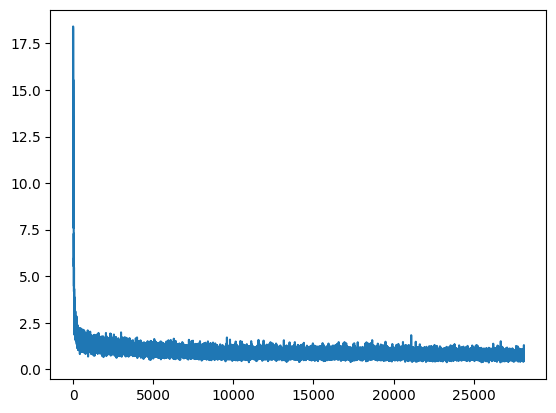

In [19]:
plt.plot(np.arange(len(losses)), np.array(losses))
plt.savefig('../reports/figures/loss.png')

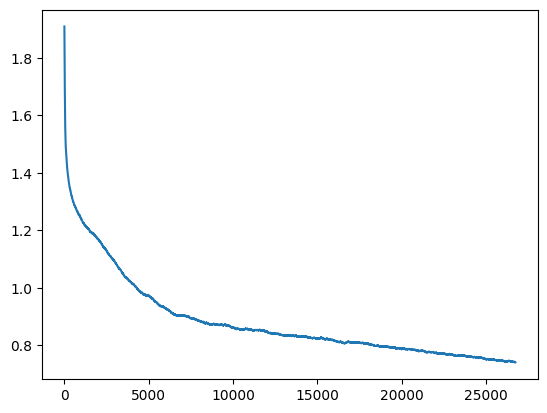

In [20]:
losses_smoothed = np.convolve(np.array(losses), np.ones(len(train_loader)) / len(train_loader), mode='valid')
plt.plot(np.arange(len(losses_smoothed)), losses_smoothed)
plt.savefig('../reports/figures/loss_smoothed.png')

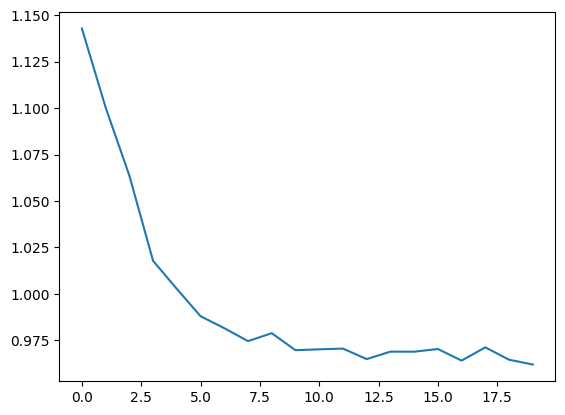

In [21]:
plt.plot(np.arange(EPOCHS), val_rmse)
plt.savefig('../reports/figures/rmse.png')

In [22]:
model.load_state_dict(torch.load(MODEL_PATH / 'last.pt'))
train_rmse = evaluate_model(train_loader)
val_rmse = evaluate_model(val_loader)
test_rmse = evaluate_model(test_loader)
print(f'''Last model metrics:
train set: {train_rmse:.3f}
val set: {val_rmse:.3f}
test set: {test_rmse:.3f}''')
model.load_state_dict(torch.load(MODEL_PATH / 'best.pt'))
train_rmse = evaluate_model(train_loader)
val_rmse = evaluate_model(val_loader)
test_rmse = evaluate_model(test_loader)
print(f'''Best model metrics:
train set: {train_rmse:.3f}
val set: {val_rmse:.3f}
test set: {test_rmse:.3f}''')

Last model metrics:
train set: 0.837
val set: 0.962
test set: 0.952
Best model metrics:
train set: 0.837
val set: 0.962
test set: 0.952
